# Proyecto Final - Tópicos avanzados en IA

- Juan Sebastián Giraldo Sepúlveda
- Juan Sebastián Navas Gómez
- Daniel Alejandro Ruiz Carrillo
- Carlos Alberto Trujillo

## Introducció y objetivos

En este proyecto trabajaremos sobre un conjunto de datos de tarjetas, transacciones y usuarios para:

1. Describir la estructura y origen de cada tabla.
2. Limpiar y fusionar los datos (merge).
3. Explorar las variables principales (estadísticas y visualizaciones).
4. Preparar un conjunto de características para modelado (si aplica).
5. Entrenar y evaluar modelos de clasificación para detectar fraudes.
6. Extraer conclusiones y recomendaciones.

**Preguntas clave**:
- ¿Qué información contiene cada archivo (`cards_data.csv`, `transactions_data.csv`, `users_data.csv`, `mcc_codes.csv`, `fraud_labels.csv`)?  
- ¿Cómo manejamos valores faltantes, formatos de fecha y columnas monetarias antes de modelar?  
- ¿Qué modelo (o combinación de modelos) logra mayor precisión/F1-score en la detección de fraudes?  


## Descripción del Dataset

### 2.1 Origen de los archivos

In [ ]:
#Importan libreriras
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.pyplot as plt
import unicodedata
import joblib  
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

In [ ]:
#Cargamos los datos desde los archivos
cards_data = pd.read_csv('cards_data.csv')
transactions_data = pd.read_csv('transactions_data.csv')
users_data = pd.read_csv('users_data.csv')

In [ ]:
# Transformamos los datos JSON a DataFrame
# 1. Abrir el archivo JSON
with open("mcc_codes.json", "r", encoding="utf-8") as f:
    mcc_dict = json.load(f)

# 2. Convertir el diccionario a una lista de tuplas y luego a DataFrame
rows = []
for code_str, desc in mcc_dict.items():
    rows.append({
        "mcc": int(code_str),              
        "mcc_description": desc             
    })

mcc_codes_df = pd.DataFrame(rows)

# 4. Ver resultado
print(mcc_codes_df.shape)
print(mcc_codes_df.head(10))

# 1. Abrir el JSON
with open("train_fraud_labels.json", "r", encoding="utf-8") as f:
    labels_dict = json.load(f)

# 2. Extraer el diccionario interno que está bajo la clave "target"
inner = labels_dict["target"]

# 3. Convertir ese sub-diccionario a lista de filas
rows = []
for id_str, label_str in inner.items():
    rows.append({
        "id": int(id_str),               # convierte "10649266" → 10649266
        "is_fraud": 1 if label_str.lower() == "yes" else 0
    })

fraud_labels_df = pd.DataFrame(rows)

# 5. Ver resultado
print(fraud_labels_df.shape)
print(fraud_labels_df.head(10))



(109, 2)
    mcc                             mcc_description
0  5812               Eating Places and Restaurants
1  5541                            Service Stations
2  7996        Amusement Parks, Carnivals, Circuses
3  5411                Grocery Stores, Supermarkets
4  4784                       Tolls and Bridge Fees
5  4900  Utilities - Electric, Gas, Water, Sanitary
6  5942                                 Book Stores
7  5814                       Fast Food Restaurants
8  4829                              Money Transfer
9  5311                           Department Stores
(8914963, 2)
         id  is_fraud
0  10649266         0
1  23410063         0
2   9316588         0
3  12478022         0
4   9558530         0
5  12532830         0
6  19526714         0
7   9906964         0
8  13224888         0
9  13749094         0


In [3]:
#Inspección inicial de los datos cards_data
print("Dimensiones iniciales de 'cards':", cards_data.shape)
print(cards_data.dtypes)
print(cards_data.head(3))

Dimensiones iniciales de 'cards': (6146, 13)
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object
     id  client_id card_brand card_type       card_number  expires  cvv  \
0  4524        825       Visa     Debit  4344676511950444  12/2022  623   
1  2731        825       Visa     Debit  4956965974959986  12/2020  393   
2  3701        825       Visa     Debit  4582313478255491  02/2024  719   

  has_chip  num_cards_issued credit_limit acct_open_date  \
0      YES                 2       $24295        09/2002   
1      YES                 2       $21968        04/2014   
2      YES                 2       $46414   

In [4]:
#Inspección inicial de los datos transactions_data
print("Dimensiones iniciales de 'transactions':", transactions_data.shape)
print(transactions_data.dtypes)
print(transactions_data.head(3))

Dimensiones iniciales de 'transactions': (13305915, 12)
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object
        id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   

  errors  
0    NaN  
1    NaN  
2  

In [5]:
#Inspección inicial de los datos users_data
print("Dimensiones iniciales de 'users_data':", users_data.shape)
print(users_data.dtypes)
print(users_data.head(3))

Dimensiones iniciales de 'users_data': (2000, 14)
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   

                  address  latitude  longitude per_capita_income  \
0           462 Rose Lane     34.15    -117.76            $29278   
1  3606 Federal Boulevard     40.76     -73.74            $37891   
2         766 Third Drive     34.

### 2.2 Variables y tipos




| Archivo                 | Columnas principales                    | Tipo                   |
|-------------------------|-----------------------------------------|------------------------|
| `cards_data.csv`        | `card_id`, `client_id`, `card_brand`, `card_type` | Numérico / Categórico |
| `transactions_data.csv` | `id`, `card_id`, `mcc`, `amount`, `date`, `city` | Numérico / Fecha / Categórico |
| `users_data.csv`        | `id`, `first_name`, `last_name`, `gender`, `city`, `job` | Numérico / Texto      |
| `mcc_codes.csv`         | `mcc`, `mcc_description`                | Numérico / Texto       |
| `fraud_labels.csv`      | `id`, `is_fraud`                        | Numérico (enteros)     |

## Limpieza y Preprocesamiento

### 3.1. Realizar merges sucesivos

In [6]:
# 1) Merge con mcc_codes_df (left, para conservar todas las transacciones)
merged = transactions_data.merge(mcc_codes_df, on='mcc', how='left')

In [7]:
# 2) Merge con fraud_labels_df (left, y rellenar NaN en is_fraud con 0)
merged = merged.merge(fraud_labels_df, on='id', how='left')
merged['is_fraud'] = merged['is_fraud'].fillna(0).astype('int8')

In [8]:
# 4) Merge con users_data usando INNER JOIN (solo transacciones con usuario asociado)
merged = merged.merge(users_data, left_on='client_id', right_on='id', how='inner', suffixes=('', '_user'))

In [9]:
# 'merged' ahora contiene únicamente las transacciones que tienen registro de tarjeta y de usuario.
merged.dtypes

id                     int64
date                  object
client_id              int64
card_id                int64
amount                object
use_chip              object
merchant_id            int64
merchant_city         object
merchant_state        object
zip                  float64
mcc                    int64
errors                object
mcc_description       object
is_fraud                int8
id_user                int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

### 3.2. Limpieza de columnas monetarias y conversión de fecha

In [ ]:
# 1. Separar las filas con fraude y sin fraude
fraud_df = merged[merged['is_fraud'] == 1]
nonfraud_df = merged[merged['is_fraud'] == 0]

# 2. Calcular cuántos registros de fraude hay
num_fraud = len(fraud_df)

# 3. Determinar cuántas filas no fraude necesitamos para llegar a 1 millón
target_total = 1_000_000
num_to_sample = target_total - num_fraud

# 4. Muestrear aleatoriamente las filas no fraude
sampled_nonfraud = nonfraud_df.sample(n=num_to_sample, random_state=42)

# 5. Concatenar todos los fraudes y la muestra de no fraudes
reduced_df = pd.concat([fraud_df, sampled_nonfraud])

# 6. Mezclar el DataFrame resultante para evitar sesgo de orden
reduced_df = reduced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Verificar dimensiones
print("Número de filas en reduced_df:", reduced_df.shape[0])
print("Número de columnas en reduced_df:", reduced_df.shape[1])

merged = reduced_df.copy()


Número de filas en reduced_df: 1000000
Número de columnas en reduced_df: 28


In [ ]:
#Merge
print(merged.dtypes)
print(merged.shape)
print(merged.head(3))

id                     int64
date                  object
client_id              int64
card_id                int64
amount                object
use_chip              object
merchant_id            int64
merchant_city         object
merchant_state        object
zip                  float64
mcc                    int64
errors                object
mcc_description       object
is_fraud                int8
id_user                int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
(1000000, 28)
         id                 date  client_id  card_id  amount  \
0  21560438  2018-07-22 13:53:00        986     4755   $2.27   
1  18621128  2016-11-06 12:51:00

In [12]:
# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Opcional: que no se trunque el ancho de cada columna
pd.set_option('display.max_colwidth', None)

print(merged.head())

         id                 date  client_id  card_id  amount  \
0  21560438  2018-07-22 13:53:00        986     4755   $2.27   
1  18621128  2016-11-06 12:51:00        421     5560   $1.37   
2  10514810  2011-12-26 18:22:00        519     3380  $26.08   
3  14283727  2014-04-17 07:43:00        573     3268  $71.68   
4  11411543  2012-07-18 14:12:00        126     5872  $33.11   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0   Chip Transaction        14528   Garden City             NY  11530.0  5499   
1   Chip Transaction        14528  Cedar Rapids             IA  52405.0  5499   
2  Swipe Transaction        87625    Washington             UT  84780.0  5812   
3  Swipe Transaction        54850       Augusta             GA  30906.0  4814   
4  Swipe Transaction        10800   Little Rock             AR  72209.0  7230   

                 errors                mcc_description  is_fraud  id_user  \
0                   NaN      Miscellaneous Food Sto

In [13]:
import matplotlib.pyplot as plt

In [ ]:
# 2) Limpieza de columnas monetarias: quitar '$' y convertir a float
for col in ['amount', 'per_capita_income', 'yearly_income', 'total_debt']:
    merged[col] = merged[col].astype(str).str.replace('[\$,]', '', regex=True)
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
C:\Users\danie\AppData\Local\Temp\ipykernel_30108\3696919354.py:3: SyntaxWarning: invalid escape sequence '\$'
  merged[col] = merged[col].astype(str).str.replace('[\$,]', '', regex=True)


In [ ]:
# 3) Transformación de 'date' a datetime y creación de nuevas columnas
merged['date'] = pd.to_datetime(merged['date'], format='%Y-%m-%d %H:%M:%S')

# Hora del día
merged['hour'] = merged['date'].dt.hour

# Día de la semana (0 = lunes, 6 = domingo)
merged['weekday'] = merged['date'].dt.weekday

# Indicador de fin de semana (1 = sábado/domingo, 0 = resto)
merged['is_weekend'] = merged['weekday'].isin([5, 6]).astype(int)

# Mes del año
merged['month'] = merged['date'].dt.month

# Indicador de "transacción nocturna" (< 6 AM o > 10 PM)
merged['is_night'] = merged['hour'].apply(lambda x: 1 if (x < 6 or x > 22) else 0)


### 3.3 Parte Enfocada en Visualizaciones de Fraude

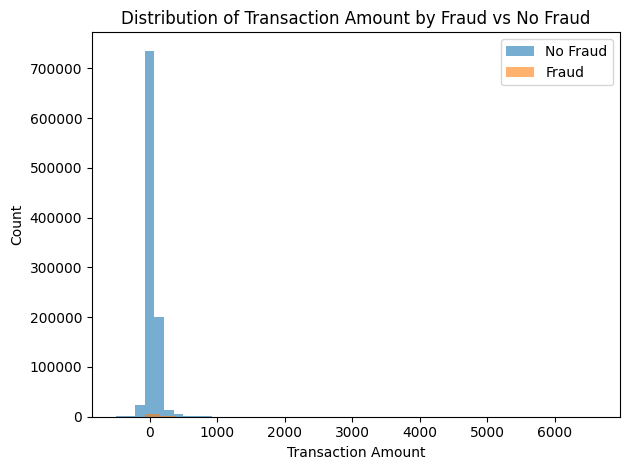

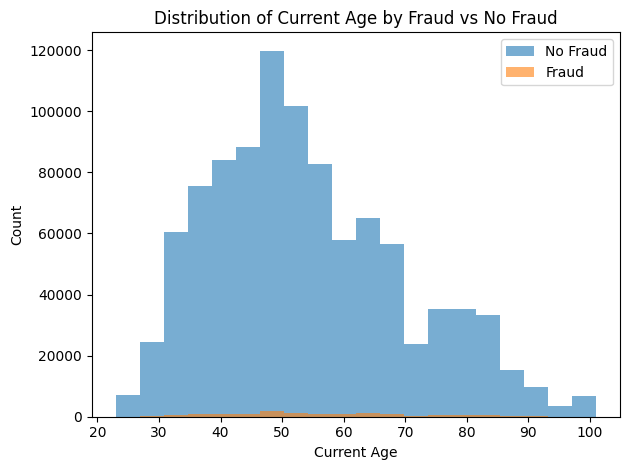

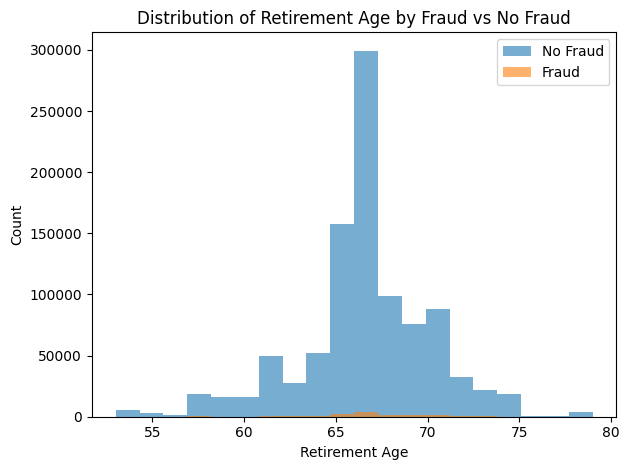

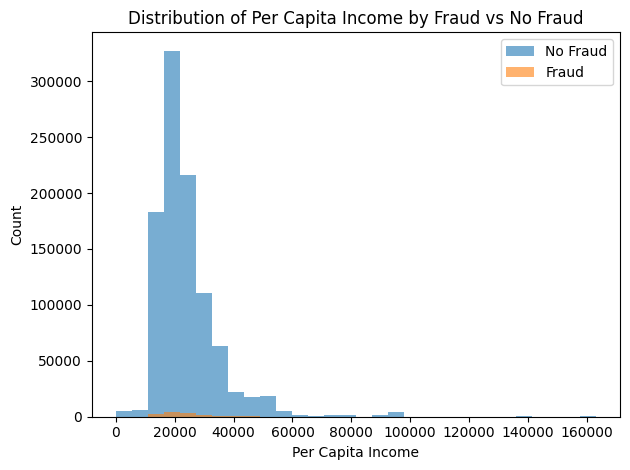

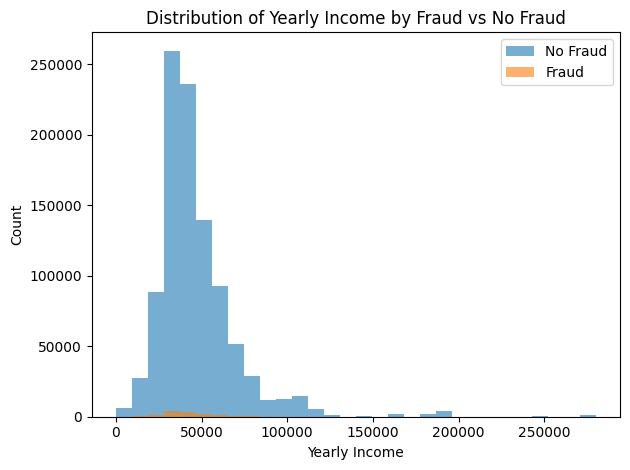

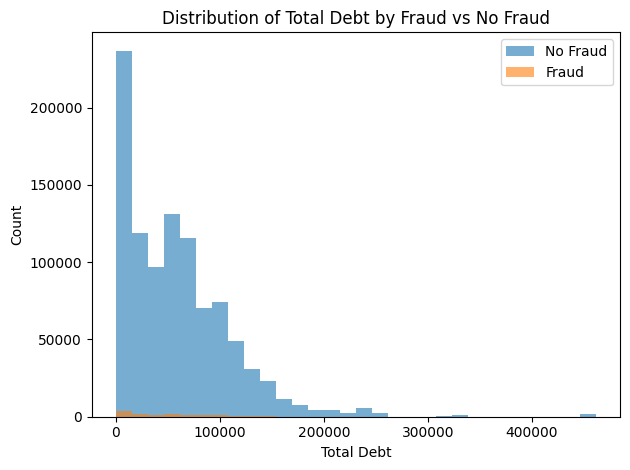

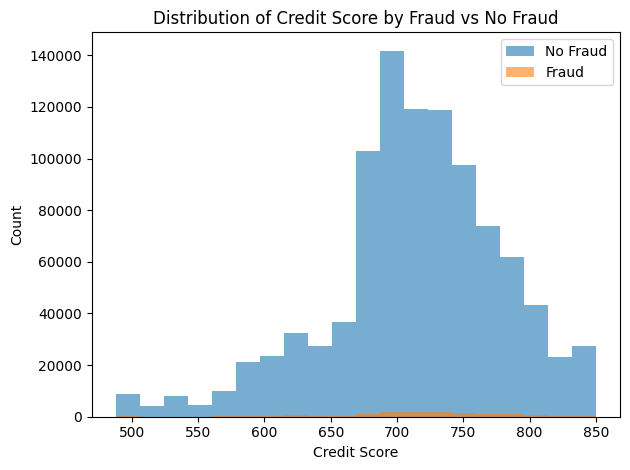

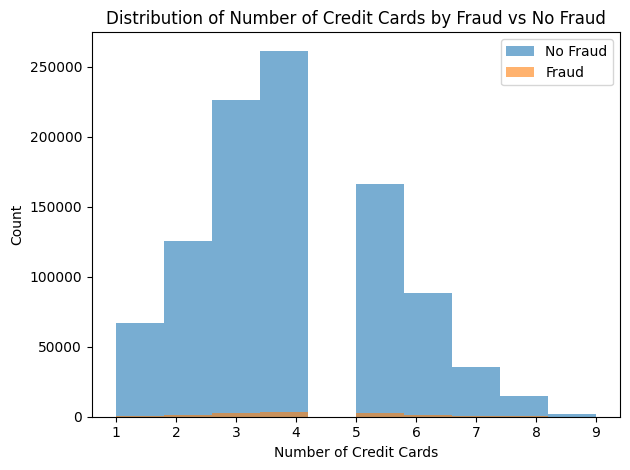

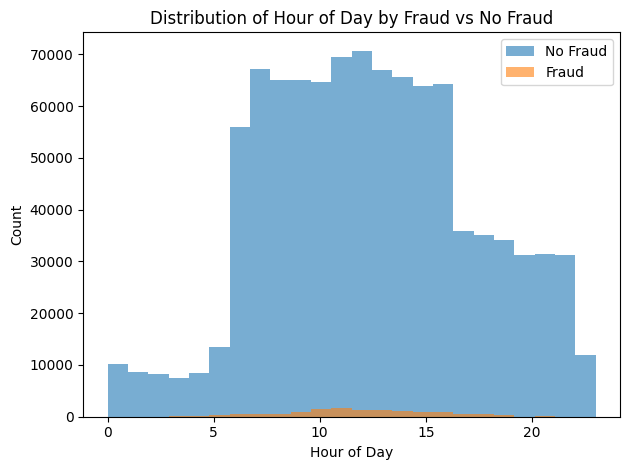

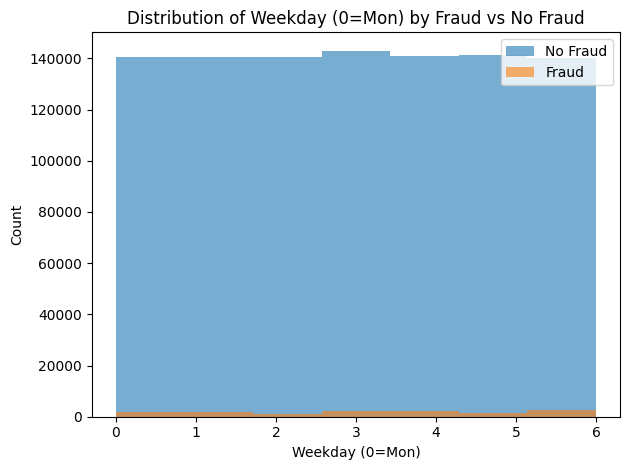

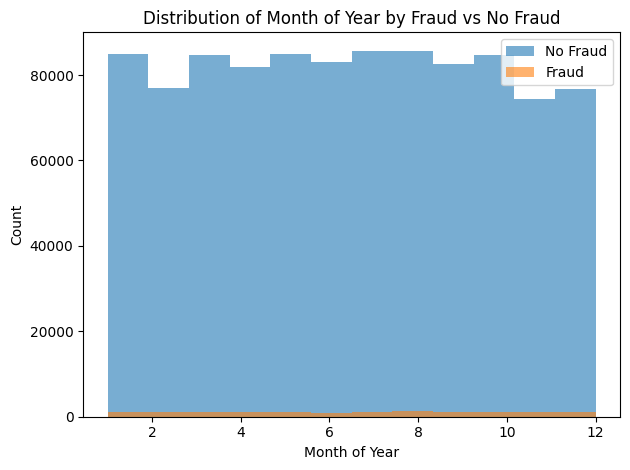

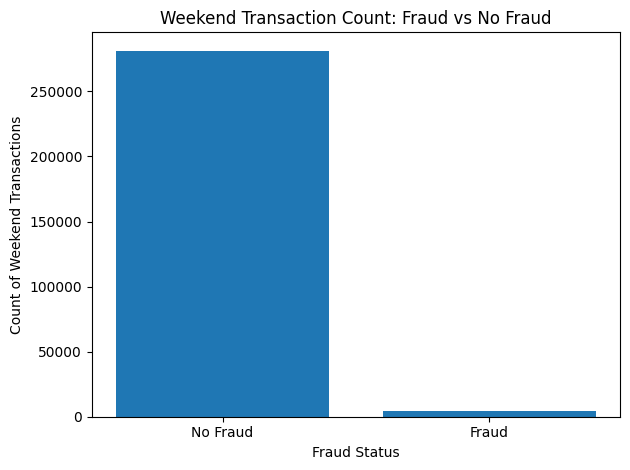

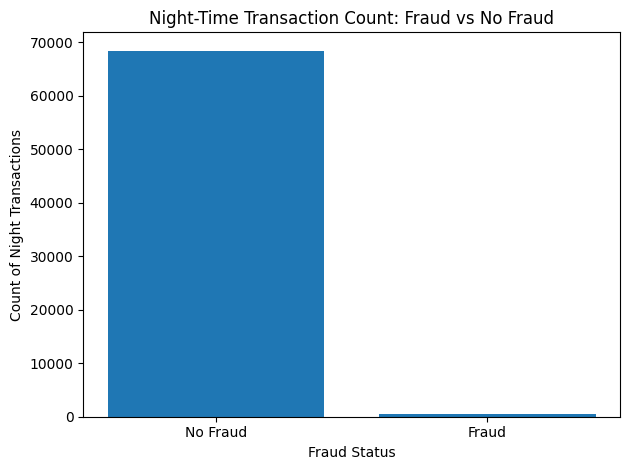

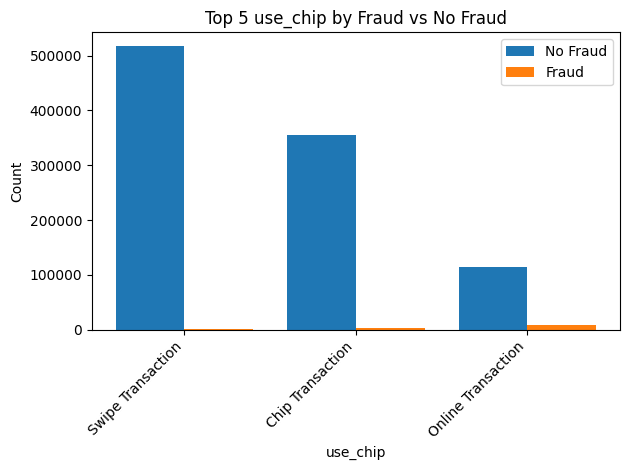

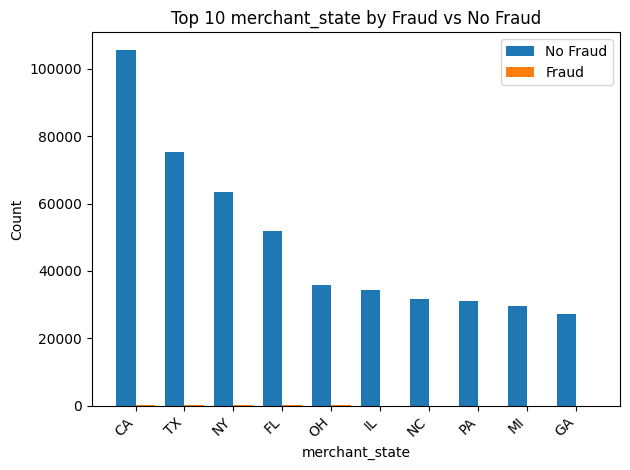

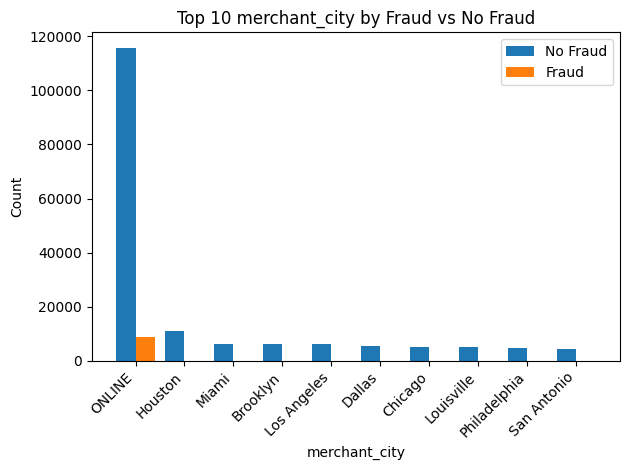

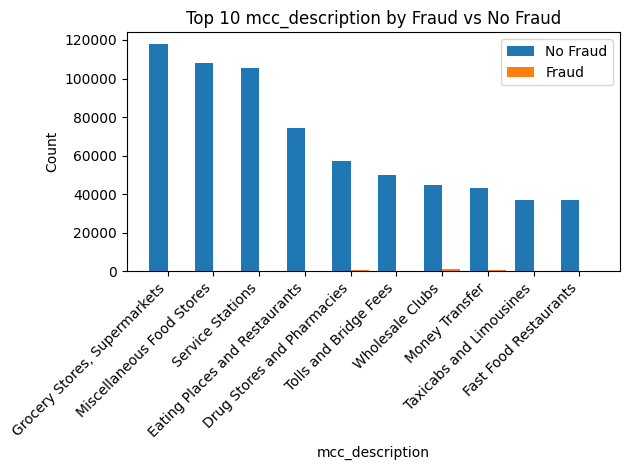

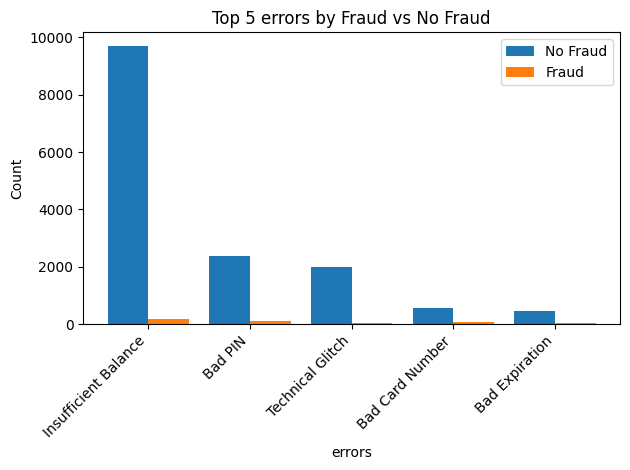

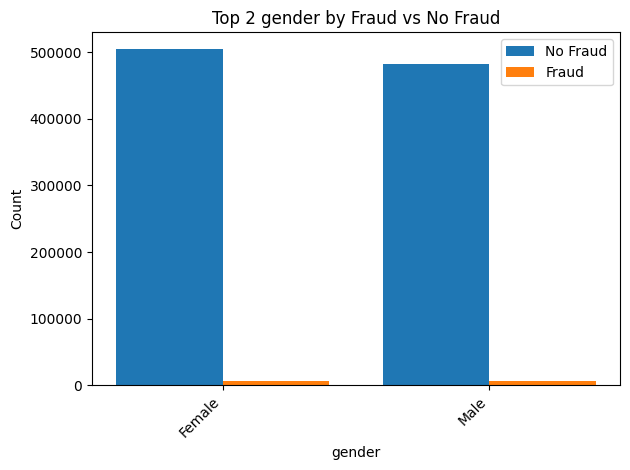

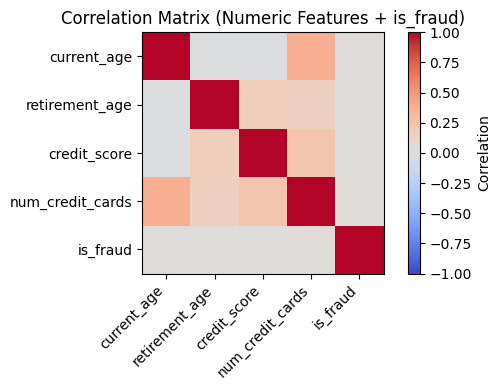

In [ ]:
# 4) Dividir en dos DataFrames: fraudes y no fraudes
fraud_df = merged[merged['is_fraud'] == 1]
nonfraud_df = merged[merged['is_fraud'] == 0]

# Función auxiliar para generar histogramas comparados
def plot_hist_comparison(col, bins=30, xlabel=None):
    plt.figure()
    plt.hist(nonfraud_df[col].dropna(), bins=bins, alpha=0.6, label='No Fraud')
    plt.hist(fraud_df[col].dropna(), bins=bins, alpha=0.6, label='Fraud')
    plt.xlabel(xlabel or col)
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'Distribution of {xlabel or col} by Fraud vs No Fraud')
    plt.tight_layout()

# Función auxiliar para generar barras comparadas en variables categóricas
def plot_bar_comparison(col, top_n=10):
    # Contar valores en no fraudes y fraudes
    counts_nonfraud = nonfraud_df[col].value_counts().head(top_n)
    counts_fraud = fraud_df[col].value_counts().reindex(counts_nonfraud.index).fillna(0)
    
    x = range(len(counts_nonfraud))
    width = 0.4
    
    plt.figure()
    plt.bar(x, counts_nonfraud.values, width=width, label='No Fraud')
    plt.bar([i + width for i in x], counts_fraud.values, width=width, label='Fraud')
    plt.xticks([i + width/2 for i in x], counts_nonfraud.index, rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'Top {top_n} {col} by Fraud vs No Fraud')
    plt.tight_layout()

# -------------------------------------------------
# A) Distribuciones numéricas: amount, current_age, retirement_age,
#    per_capita_income, yearly_income, total_debt, credit_score, num_credit_cards
# -------------------------------------------------
plot_hist_comparison('amount', bins=50, xlabel='Transaction Amount')
plot_hist_comparison('current_age', bins=20, xlabel='Current Age')
plot_hist_comparison('retirement_age', bins=20, xlabel='Retirement Age')
plot_hist_comparison('per_capita_income', bins=30, xlabel='Per Capita Income')
plot_hist_comparison('yearly_income', bins=30, xlabel='Yearly Income')
plot_hist_comparison('total_debt', bins=30, xlabel='Total Debt')
plot_hist_comparison('credit_score', bins=20, xlabel='Credit Score')
plot_hist_comparison('num_credit_cards', bins=10, xlabel='Number of Credit Cards')

# -------------------------------------------------
# B) Variables temporales derivadas de 'date'
#    (histograma de hora, día de la semana, mes)
# -------------------------------------------------
plot_hist_comparison('hour', bins=24, xlabel='Hour of Day')
plot_hist_comparison('weekday', bins=7, xlabel='Weekday (0=Mon)')
plot_hist_comparison('month', bins=12, xlabel='Month of Year')

# Contar transacciones de fin de semana
plt.figure()
plt.bar([0, 1], [nonfraud_df['is_weekend'].sum(), fraud_df['is_weekend'].sum()],
        tick_label=['No Fraud', 'Fraud'])
plt.xlabel('Fraud Status')
plt.ylabel('Count of Weekend Transactions')
plt.title('Weekend Transaction Count: Fraud vs No Fraud')
plt.tight_layout()

# Contar transacciones nocturnas
plt.figure()
plt.bar([0, 1], [nonfraud_df['is_night'].sum(), fraud_df['is_night'].sum()],
        tick_label=['No Fraud', 'Fraud'])
plt.xlabel('Fraud Status')
plt.ylabel('Count of Night Transactions')
plt.title('Night-Time Transaction Count: Fraud vs No Fraud')
plt.tight_layout()

# -------------------------------------------------
# C) Variables categóricas: use_chip, merchant_city, merchant_state,
#    mcc_description, errors, gender
# -------------------------------------------------
plot_bar_comparison('use_chip', top_n=5)
plot_bar_comparison('merchant_state', top_n=10)
plot_bar_comparison('merchant_city', top_n=10)
plot_bar_comparison('mcc_description', top_n=10)
plot_bar_comparison('errors', top_n=5)
plot_bar_comparison('gender', top_n=2)

# -------------------------------------------------
# D) Correlación de variables numéricas con is_fraud (heatmap simplificado)
# -------------------------------------------------
numeric_cols = ['current_age', 'retirement_age', 'credit_score', 'num_credit_cards']
corr_df = merged[numeric_cols + ['is_fraud']].corr()

plt.figure(figsize=(6, 4))
plt.imshow(corr_df, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title('Correlation Matrix (Numeric Features + is_fraud)')
plt.tight_layout()

# -------------------------------------------------
# Mostrar todas las gráficas generadas
# -------------------------------------------------
plt.show()

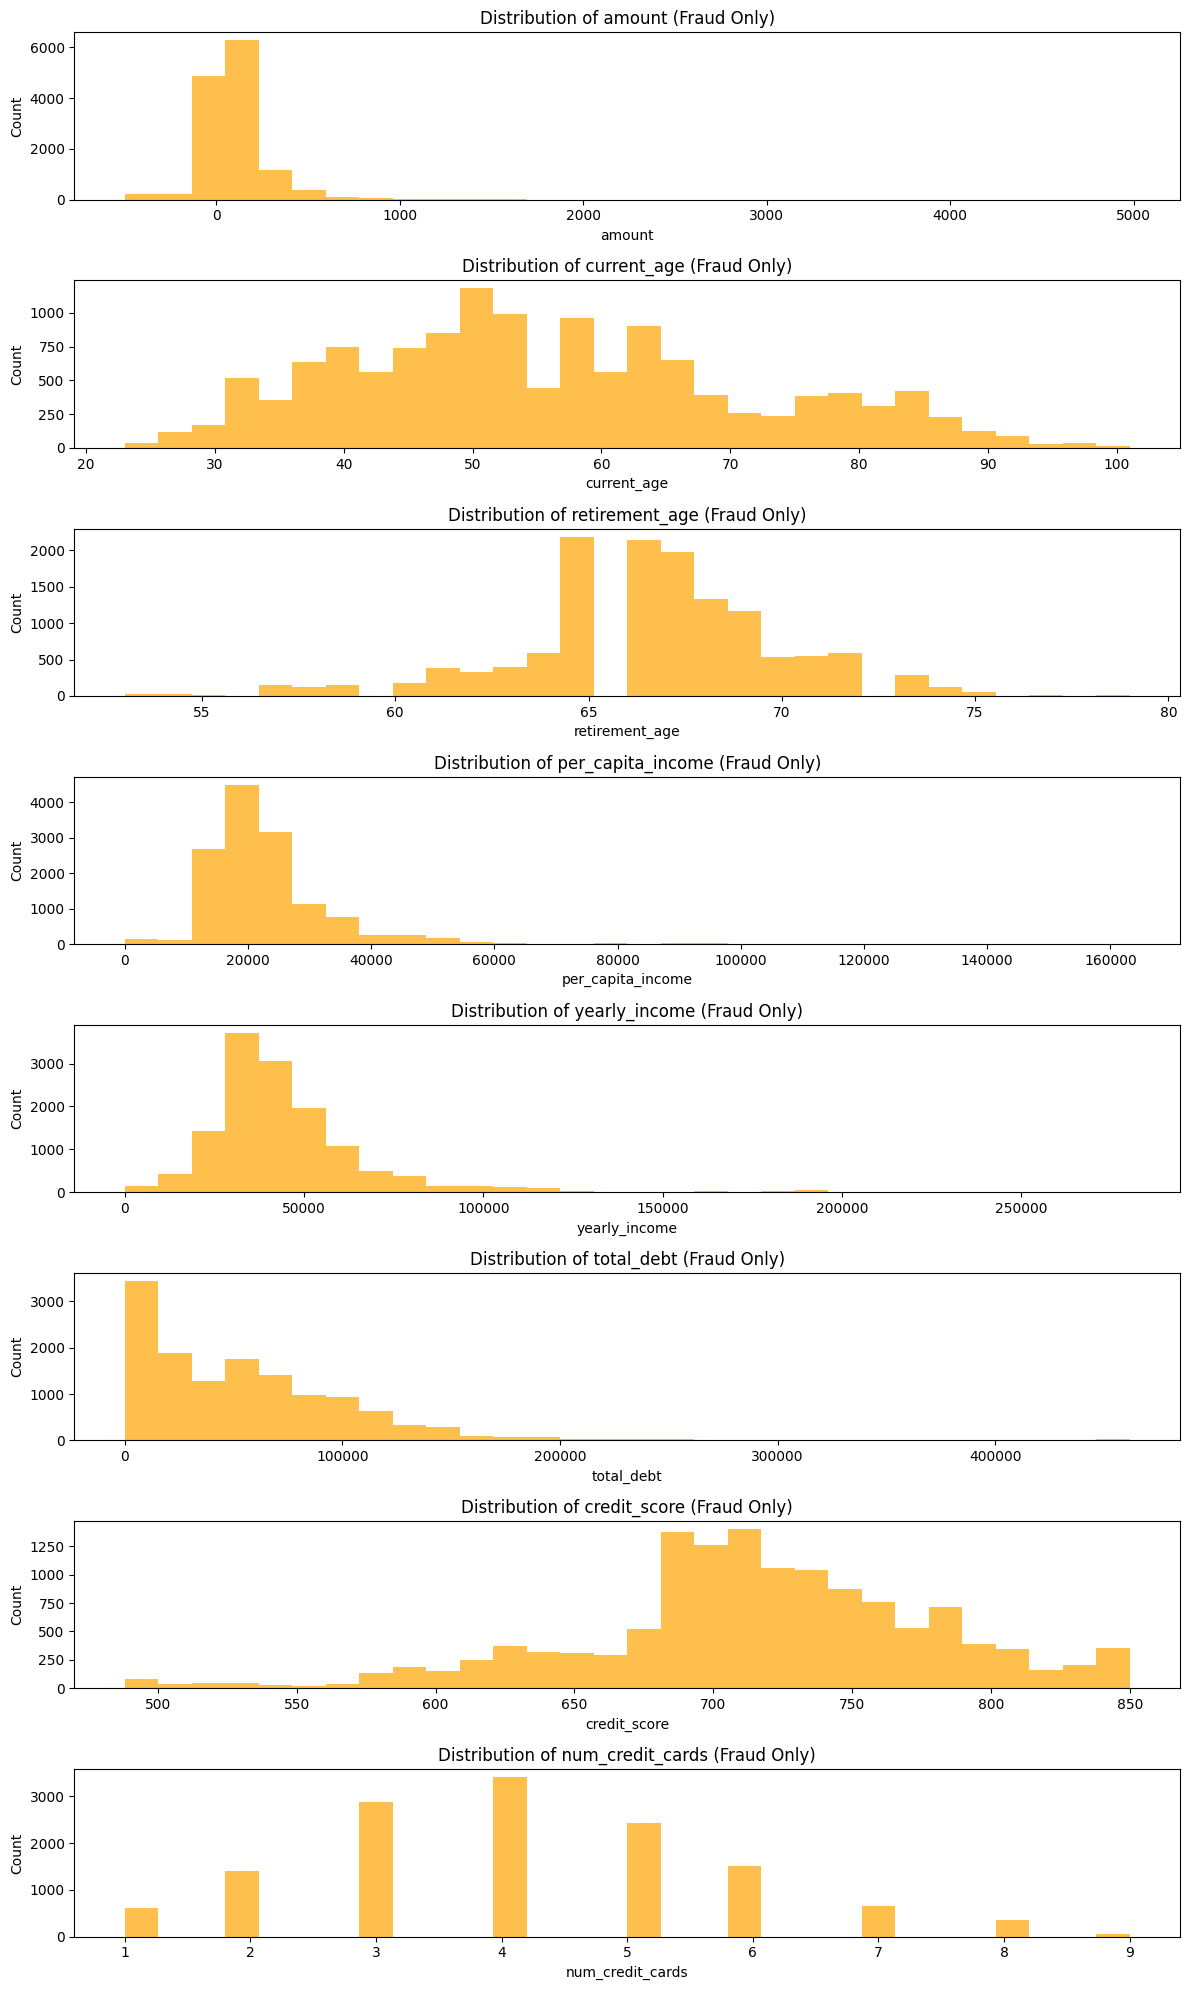

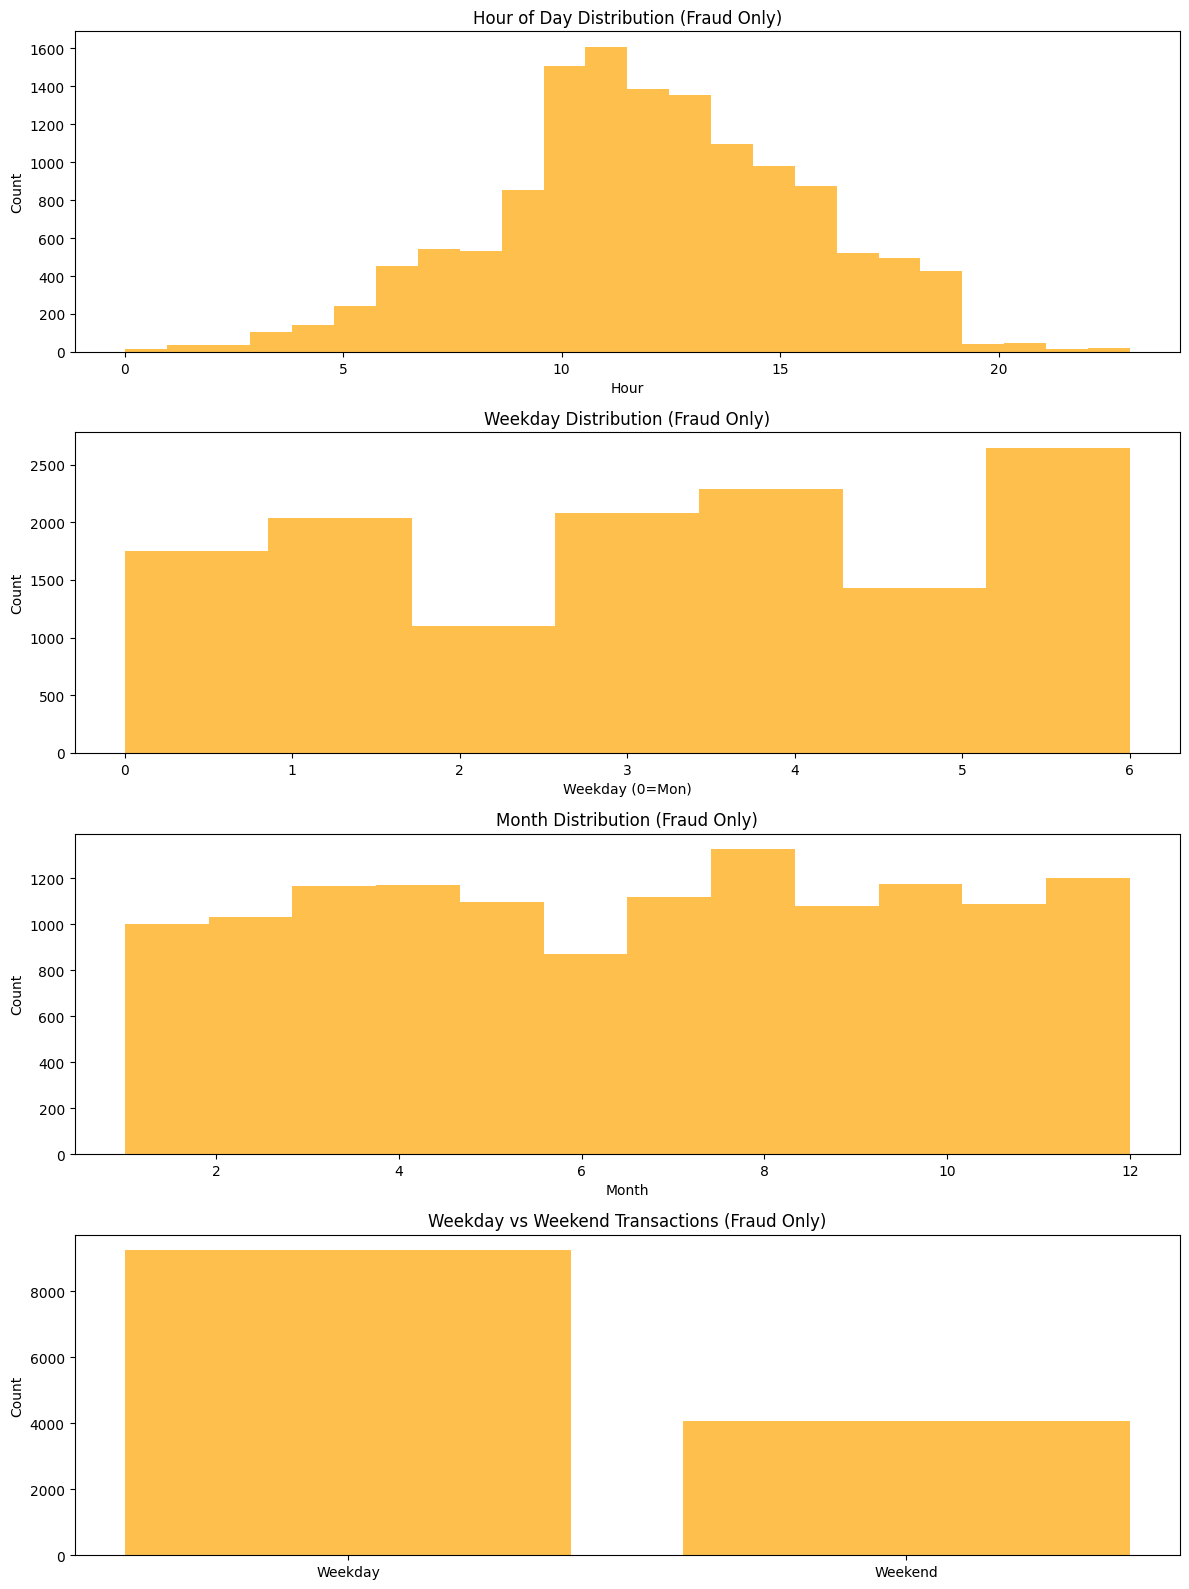

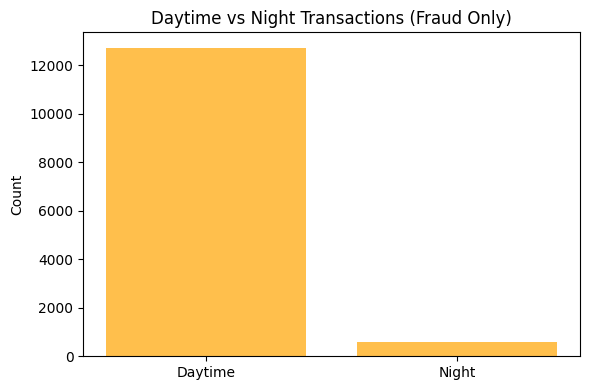

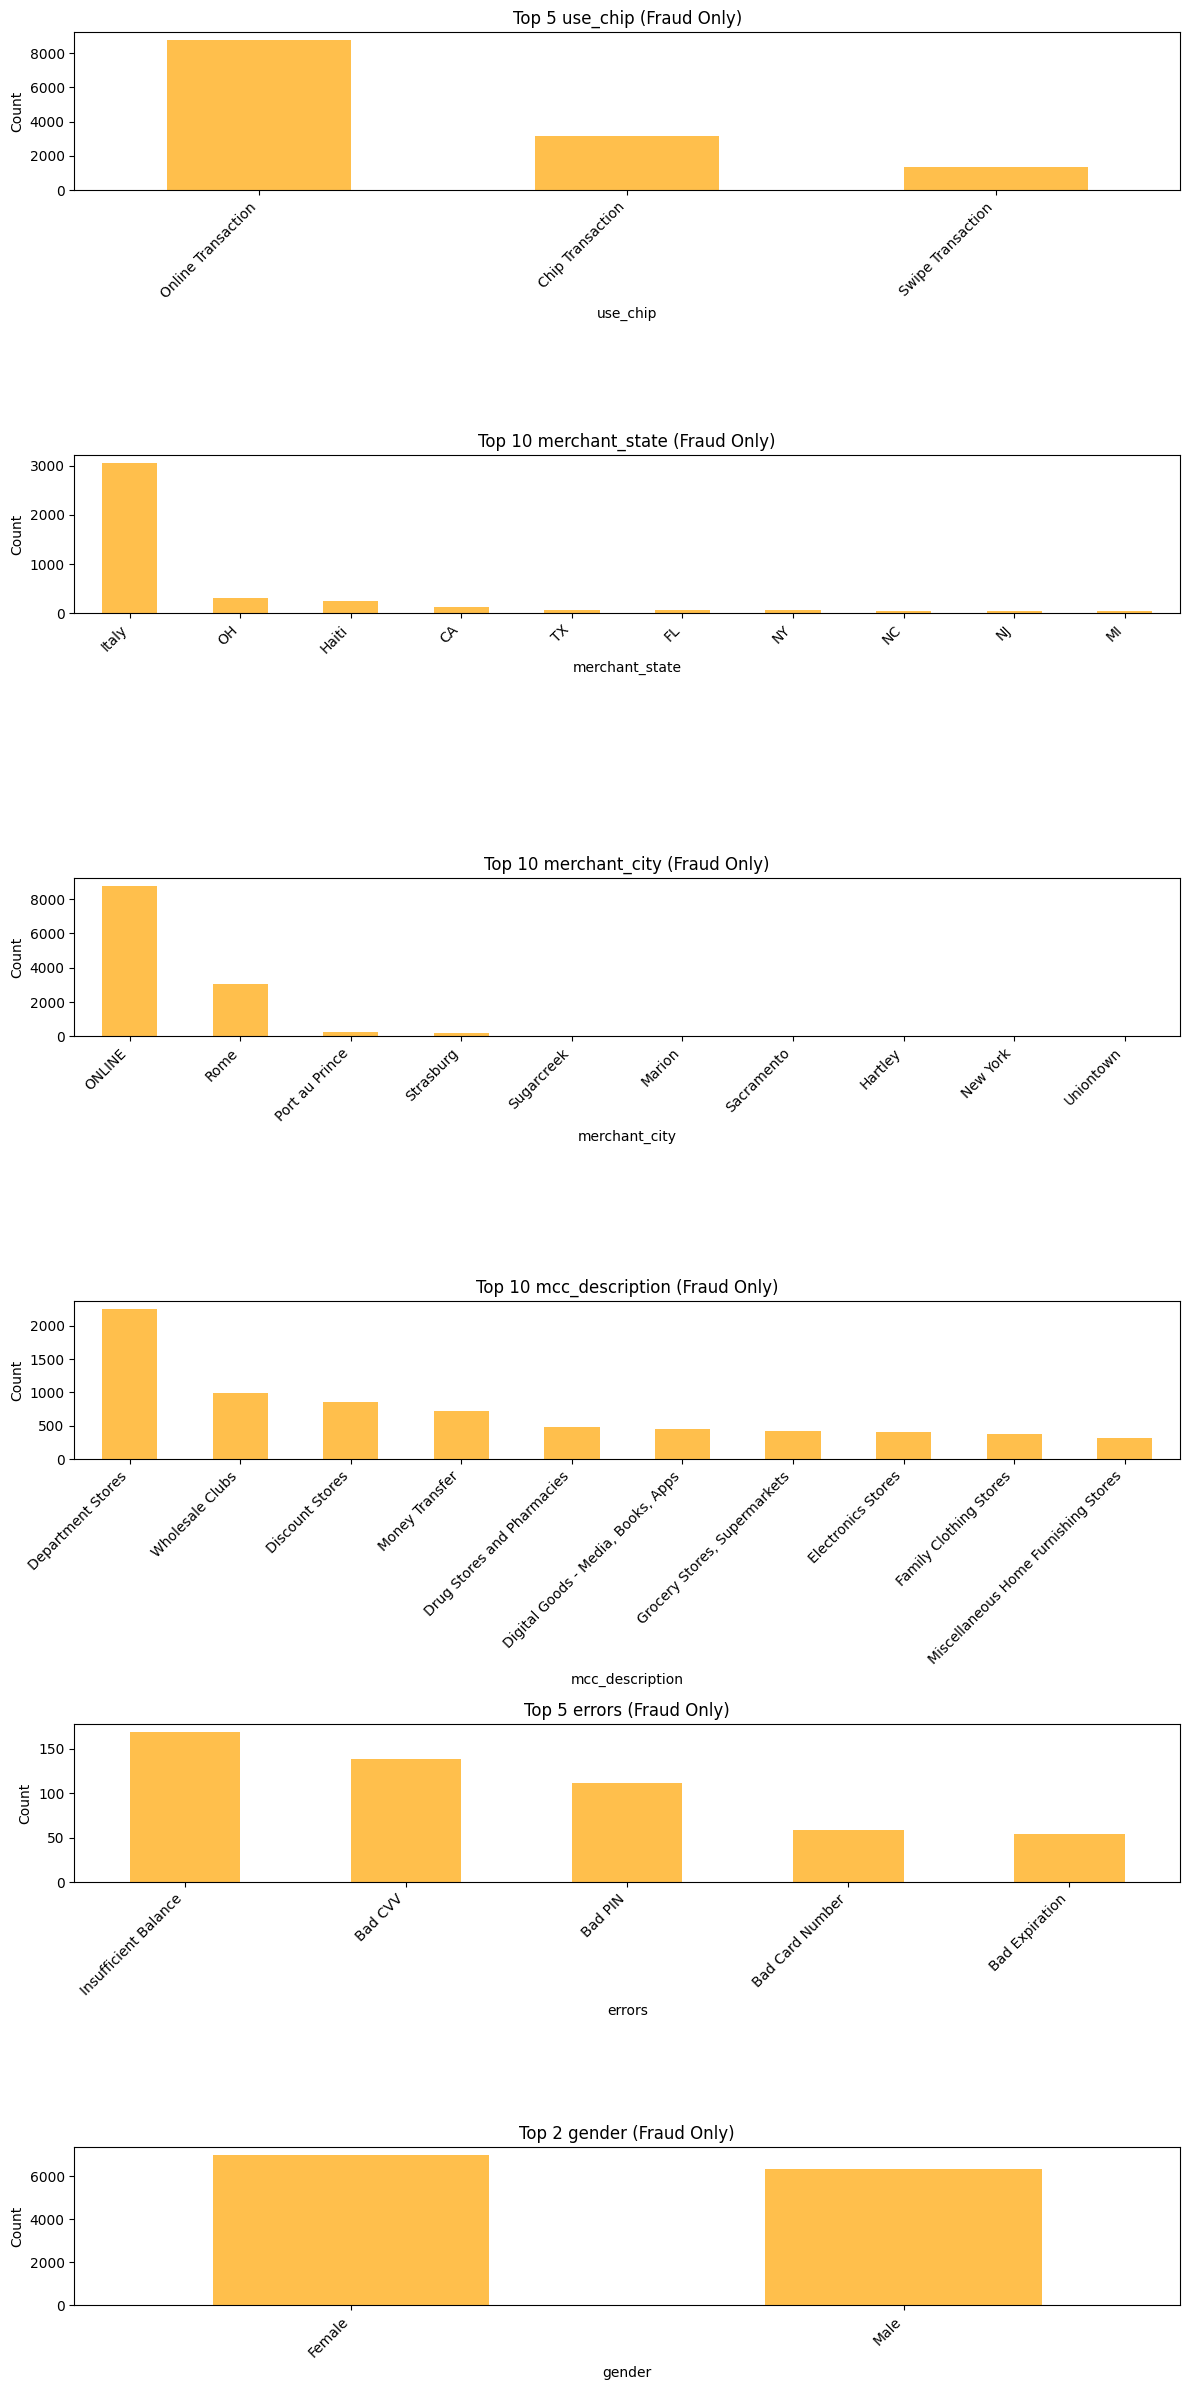

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Filtrar solo transacciones fraudulentas
fraud_df = merged[merged['is_fraud'] == 1]

# 2) Distribuciones numéricas solo para fraudes
numeric_cols = [
    'amount', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt',
    'credit_score', 'num_credit_cards'
]

plt.figure(figsize=(12, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    plt.hist(fraud_df[col].dropna(), bins=30, color='orange', alpha=0.7)
    plt.title(f'Distribution of {col} (Fraud Only)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()

plt.show()

# 3) Variables temporales: hora, día de la semana, mes, fin de semana, nocturna
plt.figure(figsize=(12, 16))

plt.subplot(4, 1, 1)
plt.hist(fraud_df['hour'].dropna(), bins=24, color='orange', alpha=0.7)
plt.title('Hour of Day Distribution (Fraud Only)')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.subplot(4, 1, 2)
plt.hist(fraud_df['weekday'].dropna(), bins=7, color='orange', alpha=0.7)
plt.title('Weekday Distribution (Fraud Only)')
plt.xlabel('Weekday (0=Mon)')
plt.ylabel('Count')

plt.subplot(4, 1, 3)
plt.hist(fraud_df['month'].dropna(), bins=12, color='orange', alpha=0.7)
plt.title('Month Distribution (Fraud Only)')
plt.xlabel('Month')
plt.ylabel('Count')

plt.subplot(4, 1, 4)
plt.bar(
    ['Weekday', 'Weekend'],
    [len(fraud_df[fraud_df['is_weekend'] == 0]), len(fraud_df[fraud_df['is_weekend'] == 1])],
    color='orange', alpha=0.7
)
plt.title('Weekday vs Weekend Transactions (Fraud Only)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(
    ['Daytime', 'Night'],
    [len(fraud_df[fraud_df['is_night'] == 0]), len(fraud_df[fraud_df['is_night'] == 1])],
    color='orange', alpha=0.7
)
plt.title('Daytime vs Night Transactions (Fraud Only)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 4) Variables categóricas (sin One-Hot Encoding), solo fraudes
categorical_cols = {
    'use_chip': 5,
    'merchant_state': 10,
    'merchant_city': 10,
    'mcc_description': 10,
    'errors': 5,
    'gender': 2
}

plt.figure(figsize=(12, 24))
plot_index = 1
for col, top_n in categorical_cols.items():
    counts = fraud_df[col].value_counts().head(top_n)
    plt.subplot(len(categorical_cols), 1, plot_index)
    counts.plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Top {top_n} {col} (Fraud Only)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_index += 1

plt.show()



In [18]:
print(merged.dtypes)
print(merged.shape)
print(merged.head(3))

id                            int64
date                 datetime64[ns]
client_id                     int64
card_id                       int64
amount                      float64
use_chip                     object
merchant_id                   int64
merchant_city                object
merchant_state               object
zip                         float64
mcc                           int64
errors                       object
mcc_description              object
is_fraud                       int8
id_user                       int64
current_age                   int64
retirement_age                int64
birth_year                    int64
birth_month                   int64
gender                       object
address                      object
latitude                    float64
longitude                   float64
per_capita_income             int64
yearly_income                 int64
total_debt                    int64
credit_score                  int64
num_credit_cards            

### 3.4. Codificación de variables categóricas

In [19]:
from sklearn.preprocessing import StandardScaler

# 1) Definir las columnas a usar
features = [
    'amount', 'use_chip', 'merchant_state', 'mcc', 'errors',
    'current_age', 'gender', 'per_capita_income', 'yearly_income',
    'total_debt', 'credit_score', 'num_credit_cards',
    'hour', 'weekday', 'is_weekend', 'month', 'is_night'
]

In [20]:
# 2) Filtrar el DataFrame con solo estas columnas
df = merged[features].copy()

# 3) Especificar qué columnas son categóricas y necesitan One-Hot Encoding
cat_cols = [
    'use_chip', 'merchant_state', 'mcc', 'errors',
    'gender', 'weekday', 'month'
]

# 4) Aplicar One-Hot Encoding con drop_first=True para evitar multicolinealidad
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [21]:
# 5) Normalizar las columnas numéricas restantes
numeric_cols = [
    'amount', 'current_age', 'per_capita_income', 'yearly_income',
    'total_debt', 'credit_score', 'num_credit_cards',
    'hour', 'is_weekend', 'is_night'
]

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# 6) Revisar estructura final
print("Shape after encoding and scaling:", df_encoded.shape)
df_encoded.head(5)

Shape after encoding and scaling: (1000000, 328)


,amount,current_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,hour,is_weekend,is_night,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_state_AK,merchant_state_AL,merchant_state_AR,merchant_state_AZ,merchant_state_Algeria,merchant_state_Andorra,merchant_state_Antigua and Barbuda,merchant_state_Argentina,merchant_state_Aruba,merchant_state_Australia,merchant_state_Austria,merchant_state_Azerbaijan,merchant_state_Bahrain,merchant_state_Bangladesh,merchant_state_Barbados,merchant_state_Belgium,merchant_state_Belize,merchant_state_Bosnia and Herzegovina,merchant_state_Brazil,merchant_state_Burkina Faso,merchant_state_CA,merchant_state_CO,merchant_state_CT,merchant_state_Cabo Verde,merchant_state_Cameroon,merchant_state_Canada,merchant_state_Chile,merchant_state_China,merchant_state_Colombia,merchant_state_Costa Rica,merchant_state_Cote d'Ivoire,merchant_state_Croatia,merchant_state_Czech Republic,merchant_state_DC,merchant_state_DE,merchant_state_Denmark,merchant_state_Dominican Republic,merchant_state_East Timor (Timor-Leste),merchant_state_Ecuador,merchant_state_Egypt,merchant_state_Eritrea,merchant_state_Estonia,merchant_state_FL,merchant_state_Finland,merchant_state_France,merchant_state_GA,merchant_state_Georgia,merchant_state_Germany,merchant_state_Ghana,merchant_state_Greece,merchant_state_Guatemala,merchant_state_HI,merchant_state_Haiti,merchant_state_Honduras,merchant_state_Hong Kong,merchant_state_Hungary,merchant_state_IA,merchant_state_ID,merchant_state_IL,merchant_state_IN,merchant_state_Iceland,merchant_state_India,merchant_state_Indonesia,merchant_state_Iran,merchant_state_Iraq,merchant_state_Ireland,merchant_state_Israel,merchant_state_Italy,merchant_state_Jamaica,merchant_state_Japan,merchant_state_Jordan,merchant_state_KS,merchant_state_KY,merchant_state_Kenya,merchant_state_Kyrgyzstan,merchant_state_LA,merchant_state_Latvia,merchant_state_Lebanon,merchant_state_Liberia,merchant_state_Lithuania,merchant_state_Luxembourg,merchant_state_MA,merchant_state_MD,merchant_state_ME,merchant_state_MI,merchant_state_MN,merchant_state_MO,merchant_state_MS,merchant_state_MT,merchant_state_Macedonia,merchant_state_Malaysia,merchant_state_Maldives,merchant_state_Mali,merchant_state_Marshall Islands,merchant_state_Mexico,merchant_state_Micronesia,merchant_state_Moldova,merchant_state_Mongolia,merchant_state_Montenegro,merchant_state_Morocco,merchant_state_Mozambique,merchant_state_NC,merchant_state_ND,merchant_state_NE,merchant_state_NH,merchant_state_NJ,merchant_state_NM,merchant_state_NV,merchant_state_NY,merchant_state_Nauru,merchant_state_Netherlands,merchant_state_New Zealand,merchant_state_Niger,merchant_state_Nigeria,merchant_state_Norway,merchant_state_OH,merchant_state_OK,merchant_state_OR,merchant_state_Oman,merchant_state_PA,merchant_state_Pakistan,merchant_state_Panama,merchant_state_Peru,merchant_state_Philippines,merchant_state_Poland,merchant_state_Portugal,merchant_state_Qatar,merchant_state_RI,merchant_state_Romania,merchant_state_Russia,merchant_state_SC,merchant_state_SD,merchant_state_Samoa,merchant_state_Saudi Arabia,merchant_state_Serbia,merchant_state_Seychelles,merchant_state_Singapore,merchant_state_Slovakia,merchant_state_Slovenia,merchant_state_South Africa,merchant_state_South Korea,merchant_state_South Sudan,merchant_state_Spain,merchant_state_Sri Lanka,merchant_state_Sweden,merchant_state_Switzerland,merchant_state_TN,merchant_state_TX,merchant_state_Taiwan,merchant_state_Thailand,merchant_state_The Bahamas,merchant_state_Trinidad and Tobago,merchant_state_Turkey,merchant_state_Tuvalu,merchant_state_UT,merchant_state_Ukraine,merchant_state_United Arab Emirates,merchant_state_United Kingdom,merchant_state_Uruguay,merchant_state_Uzbekistan,merchant_state_VA,merchant_state_VT,merchant_state_Vanuatu,merchant_state_Vatican City,merchant_state_Vietnam,merchant_state_WA,merchant_state_WI,merchant_state_WV,merchant_state_WY,merchant_state_Yemen,merchant_state_Za

## Modelado Predictivo (Detección de Fraude)

### 4.1. División en conjunto de entrenamiento y prueba

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# ------------------------------
# 1) DEFINIR X e Y (tal como antes)
# ------------------------------
X = df_encoded.copy()         # DataFrame con features One-Hot y normalizadas
y = merged['is_fraud'].values # Etiqueta de fraude (0/1)

# ------------------------------
# 2) DIVIDIR EN Train / Val / Test (70% / 15% / 15%)
# ------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Tamaños => Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
 

Tamaños => Train: (700000, 328) Val: (150000, 328) Test: (150000, 328)


### 4.2. Entrenamiento de modelos y búsqueda de hiperparámetros

In [24]:
import pickle
# ------------------------------
# 4) DEFINIR MODELOS + GRIDS REDUCIDOS
# ------------------------------
models_and_parameters = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=500, solver='liblinear', random_state=42),
        "params": {
            # grid reducido: solo un par de valores de C
            "C": [0.1, 1, 10],
            "penalty": ['l2']  # usamos solo l2 para reducir combinaciones
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            # grid reducido: menos n_estimators y max_depth
            "n_estimators": [50, 100],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50],      # solo un valor para simplificar
            "learning_rate": [0.1],    # solo un valor
            "max_depth": [3]           # solo un valor
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 5],
            "min_samples_split": [2, 10]
        }
    },

}


### 4.3. Evaluación en el conjunto de prueba

In [25]:
# 4) Entrenar, evaluar y guardar cada best_model en un diccionario
results = []
best_models = {}      # Aquí almacenaremos el objeto best_model para cada nombre

for name, mp in models_and_parameters.items():
    print(f"\nEntrenando y ajustando hiperparámetros para: {name}")
    model  = mp["model"]
    params = mp["params"]
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        cv=2,
        n_jobs=1,
        verbose=1
    )
    # Entrenamos con TODO X_train / y_train
    gs.fit(X_train, y_train)
    
    best_model = gs.best_estimator_
    best_models[name] = best_model  # Guardamos el modelo entrenado
    
    print(f"  → Mejores parámetros: {gs.best_params_}")
    
    # Evaluación en validación
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)
    print(f"  → ROC-AUC en validación: {val_auc:.4f}")
    
    # Evaluación en test
    y_test_pred  = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    acc   = accuracy_score(y_test, y_test_pred)
    prec  = precision_score(y_test, y_test_pred, zero_division=0)
    rec   = recall_score(y_test, y_test_pred, zero_division=0)
    f1    = f1_score(y_test, y_test_pred, zero_division=0)
    auc   = roc_auc_score(y_test, y_test_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    
    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "accuracy":  acc,
        "precision": prec,
        "recall":    rec,
        "f1_score":  f1,
        "roc_auc":   auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    })

print(results)

# 5) Convertir resultados a DataFrame y ordenar por ROC-AUC (u otra métrica)
results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)
print("\n=== Resultados finales (ordenados por ROC-AUC) ===")
display(results_df)

# 6) Identificar qué modelo obtuvo el mayor número de TP
best_by_tp = results_df.sort_values(by="tp", ascending=False).iloc[0]
best_model_name = best_by_tp["model"]
best_tp_value   = best_by_tp["tp"]

print(f"\n→ El modelo con mayor número de True Positives (TP = {best_tp_value}) es: {best_model_name}")

# 7) Recuperar el objeto del modelo ganador y guardarlo en un .pkl
modelo_ganador = best_models[best_model_name]

# Nombre de archivo donde lo quieras guardar
ruta_salida = "best_model_by_tp.pkl"

# Serializar con pickle
with open(ruta_salida, "wb") as f:
    pickle.dump(modelo_ganador, f)

print(f"Modelo '{best_model_name}' guardado en '{ruta_salida}'")


Entrenando y ajustando hiperparámetros para: LogisticRegression
Fitting 2 folds for each of 3 candidates, totalling 6 fits
  → Mejores parámetros: {'C': 10, 'penalty': 'l2'}
  → ROC-AUC en validación: 0.9757

Entrenando y ajustando hiperparámetros para: RandomForest
Fitting 2 folds for each of 8 candidates, totalling 16 fits
  → Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
  → ROC-AUC en validación: 0.9865

Entrenando y ajustando hiperparámetros para: GradientBoosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
  → Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
  → ROC-AUC en validación: 0.9669

Entrenando y ajustando hiperparámetros para: DecisionTree
Fitting 2 folds for each of 4 candidates, totalling 8 fits
  → Mejores parámetros: {'max_depth': 5, 'min_samples_split': 10}
  → ROC-AUC en validación: 0.9187
[{'model': 'LogisticRegression', 'best_params': {'C': 10, 'penalty': 'l2'}, 'accuracy': 0.99

,model,best_params,accuracy,precision,recall,f1_score,roc_auc,tn,fp,fn,tp
0,RandomForest,"{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}",0.994967,0.927248,0.6755,0.781603,0.989041,147894,106,649,1351
1,LogisticRegression,"{'C': 10, 'penalty': 'l2'}",0.994427,0.915121,0.6415,0.754262,0.977292,147881,119,717,1283
2,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}",0.993020,0.922804,0.5200,0.665174,0.968201,147913,87,960,1040
3,DecisionTree,"{'max_depth': 5, 'min_samples_split': 10}",0.991373,0.941250,0.3765,0.537857,0.918889,147953,47,1247,753



→ El modelo con mayor número de True Positives (TP = 1351) es: RandomForest
Modelo 'RandomForest' guardado en 'best_model_by_tp.pkl'
